# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.301186,False,1.042313
1,0.811655,True,6.596058
2,0.766516,True,7.338039
3,0.661593,True,6.659962
4,2.343496,True,11.734157
...,...,...,...
995,1.519674,True,9.643222
996,2.292310,True,11.775713
997,1.160542,True,7.793988
998,1.425328,True,7.713643


<Axes: xlabel='v0'>

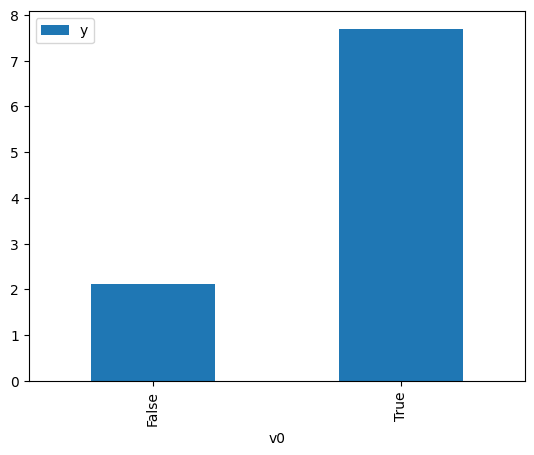

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

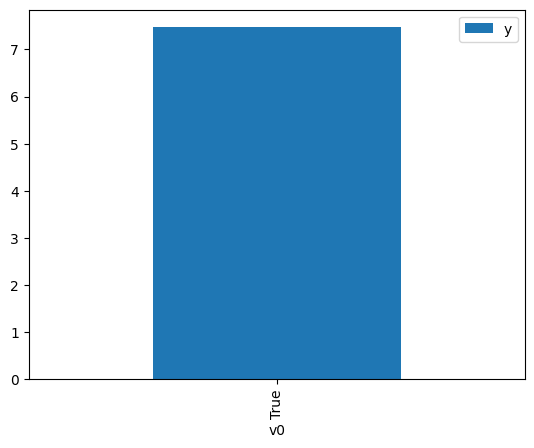

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.334809,False,2.523580,0.070441,14.196215
1,-1.356694,False,-2.405052,0.945274,1.057894
2,0.751573,False,2.686315,0.197265,5.069321
3,0.645999,False,0.176300,0.233166,4.288799
4,0.560783,False,1.851092,0.265294,3.769405
...,...,...,...,...,...
995,1.299631,False,4.398113,0.075232,13.292265
996,1.232811,False,3.883010,0.085162,11.742291
997,1.060851,False,3.086283,0.116364,8.593744
998,1.754843,False,5.241172,0.031457,31.789811


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.580815,True,7.397887,0.955898,1.046136
1,1.360499,True,9.336263,0.932877,1.071952
2,0.626459,True,4.675073,0.759713,1.316286
3,2.343496,True,11.734157,0.990191,1.009907
4,-0.436224,True,4.542532,0.270430,3.697812
...,...,...,...,...,...
995,1.936492,True,9.103130,0.977981,1.022515
996,0.479328,True,7.944845,0.701475,1.425568
997,2.136369,True,9.453021,0.985179,1.015044
998,1.868190,True,8.101663,0.974811,1.025840


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.983
Method:                 Least Squares   F-statistic:                          2.872e+04
Date:                Fri, 25 Oct 2024   Prob (F-statistic):                        0.00
Time:                        14:43:30   Log-Likelihood:                         -1423.4
No. Observations:                1000   AIC:                                      2851.
Df Residuals:                     998   BIC:                                      2861.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6696      0.038     70.632      0.000       2.595       2.744
x2             5.0716      0.060     84.656      0.000       4.954       5.189
==============================================================================
Omnibus:                        1.123   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                1.034
Skew:                           0.075   Prob(JB):                        0.596
Kurtosis:                       3.046   Cond. No.                         3.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""